# Macular Degeneration Classifier (DeiT+MLP)


### Package Installations

In [1]:
## Uncomment the following for the purposes of installation of packages if need be 
# pip install torch torchvision
# pip install skorch
# pip install scikit-learn
# pip install matplotlib seaborn
# pip install pandas
# pip install pillow

## Only uncomment this if you need to do an update for skorch
# !pip install -U skorch

### Loading Libraries

In [2]:
# basic libraries
import time
import random
import ntpath
import glob
import os
import csv
import numpy as np
import pandas as pd
import pickle
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

# torch libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
import torchvision
from torchvision import datasets, models, transforms, utils

# skorch libraries
from skorch import NeuralNetClassifier
from skorch.helper import predefined_split
from skorch.callbacks import LRScheduler, Checkpoint, Freezer
from skorch.callbacks import EpochScoring
from skorch.callbacks import EarlyStopping

# scikit-learn libraries
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold

### Experiment Name

In [3]:
NAME_OF_EXPERIMENT = "OCT DeiT + New MLP"

### Function for creating data CSV files containing paths and labels

In [4]:
import os
import csv

def create_csv(output_csv_path, dataset_root, label_mapping):
    """
    Create a CSV file containing image paths and their corresponding labels.

    Args:
    - output_csv_path (str): The path to save the output CSV file.
    - dataset_root (str): The root directory of the dataset.
    - label_mapping (dict): A dictionary mapping label names to label indices.

    Returns:
    - None
    """

    # Open the CSV file for writing
    with open(output_csv_path, 'w', newline='') as csvfile:
        # Create a CSV writer
        csv_writer = csv.writer(csvfile)

        # Write the header row
        csv_writer.writerow(['path', 'label'])

        # Traverse the dataset root and write each image path and label to the CSV file
        for root, dirs, files in os.walk(dataset_root):
            for file in files:
                if file.endswith(('.jpg', '.jpeg', '.png')):
                    # Extract the label from the directory name
                    label = os.path.basename(root)
                    
                    # Check if the label is in the label mapping
                    if label in label_mapping:
                        # Write the image path and label to the CSV file
                        path = os.path.relpath(os.path.join(root, file), dataset_root)
                        csv_writer.writerow([path, label_mapping.get(label, label)])

    print(f"data CSV file created: {output_csv_path}")



### Creating csv files for training and validation sets

In [5]:
# Using function to create a csv file
dataset_root = './archive/OCT_Balanced_Version/Balanced'  #TODO: Path to the actual location of the dataset
output_csv_path = 'train_and_validation_data.csv'  
label_mapping = {'NORMAL': 0, 'CNV': 1, 'DRUSEN': 2, 'DME': 3} 

create_csv(output_csv_path, dataset_root, label_mapping)


data CSV file created: train_and_validation_data.csv


### Creating csv files for test set

In [6]:
# Using function to create a csv file
dataset_root = './archive/test/test'  #TODO: Path to the actual location of the dataset
output_csv_path = 'test_data.csv' 
label_mapping = {'NORMAL': 0, 'CNV': 1, 'DRUSEN': 2, 'DME': 3} 

create_csv(output_csv_path, dataset_root, label_mapping)


data CSV file created: test_data.csv


### Function to read CSV file

In [7]:
import pandas as pd

def read_data_csv(csv_file, dataset_root, class_names):
    """
    Read the data CSV file, make image paths relative, store the number of classes,
    and define class names.

    Args:
    - csv_file (str): The path to the data CSV file.
    - dataset_root (str): The root directory of the dataset.
    - class_names (list): A list of class names.

    Returns:
    - data (pd.DataFrame): DataFrame containing the data from the CSV file.
    - NUMBER_OF_CLASSES (int): Number of unique classes.
    """

    # Reading the data CSV file
    data = pd.read_csv(csv_file)

    # Making image path relative
    data['path'] = dataset_root + '/' + data['path'].str.replace('\\', '/', regex=True)

    # Storing the number of classes
    NUMBER_OF_CLASSES = len(class_names)

    # Displaying the first few rows
    print(data.head())

    return data, NUMBER_OF_CLASSES



### Reading the data csv files

In [8]:
# Using function to read the data CSV file
csv_file = "train_and_validation_data.csv" 
dataset_root = './archive/OCT_Balanced_Version/Balanced'  #TODO: Path to the actual location of the dataset
class_names = ['DME', 'CNV', 'DRUSEN', 'NORMAL'] 

data, NUMBER_OF_CLASSES = read_data_csv(csv_file, dataset_root, class_names)


                                                path  label
0  ./archive/OCT_Balanced_Version/Balanced/CNV/CN...      1
1  ./archive/OCT_Balanced_Version/Balanced/CNV/CN...      1
2  ./archive/OCT_Balanced_Version/Balanced/CNV/CN...      1
3  ./archive/OCT_Balanced_Version/Balanced/CNV/CN...      1
4  ./archive/OCT_Balanced_Version/Balanced/CNV/CN...      1


In [9]:
# Using function to read the data CSV file
csv_file = "test_data.csv" 
dataset_root = './archive/test/test'  #TODO: Path to the actual location of the dataset
class_names = ['DME', 'CNV', 'DRUSEN', 'NORMAL'] 

test_data, NUMBER_OF_CLASSES = read_data_csv(csv_file, dataset_root, class_names)


                                         path  label
0  ./archive/test/test/CNV/CNV-1016042-1.jpeg      1
1  ./archive/test/test/CNV/CNV-1016042-2.jpeg      1
2  ./archive/test/test/CNV/CNV-1016042-3.jpeg      1
3  ./archive/test/test/CNV/CNV-1016042-4.jpeg      1
4   ./archive/test/test/CNV/CNV-103044-1.jpeg      1


## Checking the distribution of the following classes

'NORMAL': 0

'CNV': 1

'DRUSEN': 2

'DME': 3

In [10]:
# checking the distribution of classes
data.label.value_counts()

1    8016
3    8016
0    8016
2    8015
Name: label, dtype: int64

In [11]:
# checking the distribution of classes
test_data.label.value_counts()

1    242
3    242
2    242
0    242
Name: label, dtype: int64

## Dataset Class

In [13]:
class Dataset_Loader(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X.reset_index().drop('index', axis=1).path
        self.y = torch.tensor(y.reset_index().drop('index', axis=1).label, dtype=torch.long)
        self.transform = transform

        assert len(self.X) == len(self.y), f'X and y have different lengths -> {len(self.X)} != {len(self.y)} '

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img_path = self.X[idx]
        img = Image.open(img_path)

        # Convert grayscale to RGB if the image is grayscale
        if img.mode != 'RGB':
            img = img.convert('RGB')

        if self.transform is not None:
            img = self.transform(img)

        label = self.y[idx]
        return (img, label)
    
    def show_img(self, idx):
        '''Plot image'''
        img, label = self.__getitem__(idx)
        if img is not None:
            # Normalize pixel values to [0, 1] range
            img = img.numpy().transpose((1, 2, 0))
            img = (img - img.min()) / (img.max() - img.min())
            plt.figure(figsize=(16, 8))
            plt.axis('off')
            plt.imshow(img)
            plt.title(label)
            plt.pause(0.001)


## Transformations

In [14]:
# Defining the transformation for the training, validation and test sets
class TRANSFORMATIONS:
    """Contains all the necessary transformations for the training, validation and test sets"""
    TRAIN_TRANSFORMS = transforms.Compose([
        # transforms.RandomResizedCrop(224),  # Random resized cropping
        # transforms.RandomHorizontalFlip(),  # Random horizontal flipping
        # transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),  # Color jitter
        # transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.1),  # Gaussian blur       
        
        # Rotate the image by given angle.
        transforms.RandomRotation(5),
        # Crop the given PIL Image to a given size
        transforms.Resize((224,224)),
        # Horizontally flip the given PIL Image randomly with a given probability.
        transforms.RandomHorizontalFlip(p = 0.2),
        #Convert a PIL Image or numpy.ndarray to tensor.
        transforms.ToTensor(),
        #Normalize a tensor image with mean and standard deviation
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])
    ])

    VAL_TRANSFORMS = transforms.Compose([
        #Crop the given PIL Image to random size and aspect ratio.
        transforms.Resize((224,224)),
        #Convert a PIL Image or numpy.ndarray to tensor.
        transforms.ToTensor(),
        #Normalize a tensor image with mean and standard deviation
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])
    ])

    TEST_TRANSFORMS = transforms.Compose([     
        #Crop the given PIL Image to random size and aspect ratio.
        transforms.Resize((224,224)),
        #Convert a PIL Image or numpy.ndarray to tensor.
        transforms.ToTensor(),
        #Normalize a tensor image with mean and standard deviation
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])
    ])

## Neural Network Configuration

In [15]:
# Setup the neural network configuration
class NEURAL_NETWORK_CONFIG:
    """Stores all neccesary configurations for the neural network""" 

    # Basics
    SEED = 1210
    TRAIN_SIZE = 4000
    NUMBER_OF_FOLDS = 10
    

    # Defining appropriate scoring metrics for multiclass classification
    ROC_AUC = EpochScoring(scoring='roc_auc_ovr', name='valid_roc_auc', lower_is_better=False)
    RECALL = EpochScoring(scoring='recall_macro', name='valid_recall', lower_is_better=False)
    PRECISION = EpochScoring(scoring='precision_macro', name='valid_precision', lower_is_better=False)
    F1 = EpochScoring(scoring='f1_macro', name='valid_f1', lower_is_better=False)
    EARLY_STOPPING = EarlyStopping(monitor='valid_loss', patience=7, lower_is_better=True)
    
    ROC_AUC_AVERAGE_PARAMETER = 'macro'
    RECALL_AVERAGE_PARAMETER = 'macro'
    PRECISION_AVERAGE_PARAMETER = 'macro'
    F1_AVERAGE_PARAMETER = 'macro'
     
    # model
    CRITERION = nn.CrossEntropyLoss 
    OPTIMIZER = optim.Adam 
    MOMENTUM = 0.9
    LR = 0.001
    BATCH_SIZE = 128
    EPOCHS = 100
    OUTPUT_FEATURES = NUMBER_OF_CLASSES 
    
    # callbacks
    LRSCHEDULER = LRScheduler(policy='StepLR', step_size=5, gamma=0.75)
    CHECKPOINT = Checkpoint(f_params='best_model.pt', monitor='valid_acc_best')
    FREEZER = Freezer(lambda x: not x.startswith('model.head'))
    CALLBACKS = [LRSCHEDULER, CHECKPOINT, FREEZER, ROC_AUC, RECALL, PRECISION, F1, EARLY_STOPPING]
    
    # device
    DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print('You are using ->', DEVICE)

You are using -> cuda:0


## Reproducibility

In [16]:
# Make results reproducible
def seed_for_reproducibility(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_for_reproducibility(NEURAL_NETWORK_CONFIG.SEED)

## Neural Network Architecture

In [17]:
# Defining the neural network architecture
class Model(nn.Module):
    def __init__(self, output_features):
        super().__init__()
        model = torch.hub.load('facebookresearch/deit:main', 'deit_base_patch16_224', pretrained=True)
        n_inputs = model.head.in_features
        model.head = nn.Sequential(
            nn.Linear(n_inputs, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 64),  
            nn.ReLU(),
            nn.Linear(64, output_features)
        )

        self.model = model

    def forward(self, x):
        return self.model(x)

## Dataset Splitting

In [18]:
# Splitting for the external_test set
data, external_test_data = train_test_split(data, train_size=NEURAL_NETWORK_CONFIG.TRAIN_SIZE, random_state=NEURAL_NETWORK_CONFIG.SEED, stratify=data.label)
data.to_csv('oct_training_validation_data.csv', index=False)
external_test_data.to_csv('oct_unused_data.csv', index=False)

# Check the distribution of classes in the training set
train_class_distribution = data["label"].value_counts()

# Check the distribution of classes in the testing set
unused_class_distribution = external_test_data["label"].value_counts()

# Display the distributions
print("Training Set Class Distribution:")
print(train_class_distribution)

print("")

print("Unused Set Class Distribution:")
print(unused_class_distribution)

print("")

# Check unique labels in the DataFrame
print("Unique class labels:", data['label'].unique())

# Check the first few rows of the dataframe to verify its structure
data.head()

Training Set Class Distribution:
3    1000
1    1000
0    1000
2    1000
Name: label, dtype: int64

Unused Set Class Distribution:
1    7016
3    7016
0    7016
2    7015
Name: label, dtype: int64

Unique class labels: [3 1 0 2]


,path,label
9606,./archive/OCT_Balanced_Version/Balanced/DME/DM...,3
10161,./archive/OCT_Balanced_Version/Balanced/DME/DM...,3
3003,./archive/OCT_Balanced_Version/Balanced/CNV/CN...,1
2135,./archive/OCT_Balanced_Version/Balanced/CNV/CN...,1
30475,./archive/OCT_Balanced_Version/Balanced/NORMAL...,0


### Creating Train, Validation and Test Dataloaders

In [19]:
# Assigning the image paths and labels to variables
X = data.path
y = data.label

# Instantiate StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=NEURAL_NETWORK_CONFIG.NUMBER_OF_FOLDS, shuffle=True, random_state=NEURAL_NETWORK_CONFIG.SEED)

# Iterate over the folds
for fold, (train_index, val_index) in enumerate(stratified_kfold.split(X, y)):
    print("")
    print(f'Training Fold {fold + 1} created')
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # Instantiate PyTorch train and validation sets for the current fold
    TRAIN = Dataset_Loader(X_train, y_train, TRANSFORMATIONS.TRAIN_TRANSFORMS)
    VAL = Dataset_Loader(X_val, y_val, TRANSFORMATIONS.VAL_TRANSFORMS)
    
    # Save TRAIN and VAL datasets to pickle files
    with open(f'TRAIN_FOLD_{fold + 1}.pkl', 'wb') as train_file:
        pickle.dump(TRAIN, train_file)
    
    with open(f'VAL_FOLD_{fold + 1}.pkl', 'wb') as val_file:
        pickle.dump(VAL, val_file)

        
# Assigning the image paths and labels to variables for test set
X_test = test_data.path
y_test = test_data.label        
TEST = Dataset_Loader(X_test, y_test, TRANSFORMATIONS.TEST_TRANSFORMS)

print("")
print(f'Test Set created')

 # Save TEST datasets to pickle files
with open(f'TEST.pkl', 'wb') as test_file:
        pickle.dump(TEST, test_file)
        
# Load the TEST dataset
with open(f'TEST.pkl', 'rb') as test_file:
    test_dataset = pickle.load(test_file)


Training Fold 1 created

Training Fold 2 created

Training Fold 3 created

Training Fold 4 created

Training Fold 5 created

Training Fold 6 created

Training Fold 7 created

Training Fold 8 created

Training Fold 9 created

Training Fold 10 created

Test Set created


# Training of model

### Loading test set using pickle files (Quality Control and Reproducibility Procedure)

In [20]:
SAMPLE_TO_ACCESS = 0

# Load the TEST dataset
with open(f'TEST.pkl', 'rb') as test_file:
    test_dataset = pickle.load(test_file)
    
print(f"Number of samples in TEST dataset:", len(test_dataset))
sample_img, sample_label = test_dataset[SAMPLE_TO_ACCESS]  # Get the specified sample from the TRAIN dataset for the fold
print("Sample image shape from test_dataset:", sample_img.shape) # Get the image shape for the specified sample from the TEST dataset
print("Sample label from test_dataset:", sample_label) # Get the image label for the specified sample from the TEST dataset

Number of samples in TEST dataset: 968
Sample image shape from test_dataset: torch.Size([3, 224, 224])
Sample label from test_dataset: tensor(1)


### Loading training and validation folds using pickle files (Quality Control and Reproducibility Procedure)

In [21]:
# Indexing the folds and samples
FOLD_TO_ACCESS = 1
SAMPLE_TO_ACCESS = 0


# Load the TRAIN dataset for a specific fold
with open(f'TRAIN_FOLD_{FOLD_TO_ACCESS}.pkl', 'rb') as train_file:
    train_dataset_for_fold = pickle.load(train_file)

# Load the VAL dataset for a specific fold
with open(f'VAL_FOLD_{FOLD_TO_ACCESS}.pkl', 'rb') as val_file:
    val_dataset_for_fold = pickle.load(val_file)


# Access the content of a given train_dataset_fold and val_dataset_for_fold
print(f"Number of samples in TRAIN dataset for fold {FOLD_TO_ACCESS}:", len(train_dataset_for_fold))
print(f"Number of samples in VAL dataset for fold {FOLD_TO_ACCESS}:", len(val_dataset_for_fold))
print()

# Access a specific sample from the train_dataset_fold:
sample_img, sample_label = train_dataset_for_fold[SAMPLE_TO_ACCESS]  # Get the specified sample from the TRAIN dataset for the fold
print("Sample image shape from train_dataset_fold:", sample_img.shape)
print("Sample label from train_dataset_fold:", sample_label)
print()

# Access a specific sample from the val_dataset_fold:
sample_img, sample_label = val_dataset_for_fold[SAMPLE_TO_ACCESS]  # Get the specified sample from the TRAIN dataset for the fold
print("Sample image shape from val_dataset_fold:", sample_img.shape)
print("Sample label from val_dataset_fold:", sample_label)

Number of samples in TRAIN dataset for fold 1: 3600
Number of samples in VAL dataset for fold 1: 400

Sample image shape from train_dataset_fold: torch.Size([3, 224, 224])
Sample label from train_dataset_fold: tensor(3)

Sample image shape from val_dataset_fold: torch.Size([3, 224, 224])
Sample label from val_dataset_fold: tensor(3)


### Function to train and evaluate model for the folds

In [22]:
import pickle
import csv
import os
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def train_and_evaluate_model(NAME_OF_EXPERIMENT, FOLD_TO_ACCESS, NEURAL_NETWORK_CONFIG, Model, predefined_split, class_names, csv_file, metrics_per_fold, trained_models):
    """
    Train and evaluate a PyTorch model for a given fold of the dataset.

    Args:
    - train_dataset_for_fold: PyTorch dataset for training.
    - val_dataset_for_fold: PyTorch dataset for validation.
    - NAME_OF_EXPERIMENT (str): Name of the experiment or model.
    - FOLD_TO_ACCESS (int): Fold number.
    - NEURAL_NETWORK_CONFIG (object): Configuration object for the neural network.
    - Model (torch.nn.Module): PyTorch model to train.
    - predefined_split: Predefined split function from scikit-learn.
    - class_names (list): List of class names.
    - csv_file (str): Path to save the metrics CSV file.
    - metrics_per_fold (list): List to store metrics for each fold.
    - trained_models (list): List to store trained models.

    Returns:
    - None
    """
    
    # Load the TRAIN dataset for a specific fold
    with open(f'TRAIN_FOLD_{FOLD_TO_ACCESS}.pkl', 'rb') as train_file:
        train_dataset_for_fold = pickle.load(train_file)

    # Load the VAL dataset for a specific fold
    with open(f'VAL_FOLD_{FOLD_TO_ACCESS}.pkl', 'rb') as val_file:
        val_dataset_for_fold = pickle.load(val_file)

    # Instantiate PyTorch train and validation sets for the current fold
    TRAIN = train_dataset_for_fold
    VAL = val_dataset_for_fold

    # Configure the filename for the checkpoint based on the fold
    checkpoint_filename = f'{NAME_OF_EXPERIMENT}_fold_{FOLD_TO_ACCESS}_best_model.pt'

    # Create the Checkpoint callback for the current fold
    CHECKPOINT_CALLBACK = Checkpoint(
        f_params=checkpoint_filename,
        monitor='valid_acc_best',
        f_history=f'{NAME_OF_EXPERIMENT}_fold_{FOLD_TO_ACCESS}_history.csv',
        f_optimizer=f'{NAME_OF_EXPERIMENT}_fold_{FOLD_TO_ACCESS}_optimizer.pt',
        f_criterion=f'{NAME_OF_EXPERIMENT}_fold_{FOLD_TO_ACCESS}_criterion.pt',
        f_history_epoch=f'{NAME_OF_EXPERIMENT}_fold_{FOLD_TO_ACCESS}_history_epoch.csv',
        f_history_batch=f'{NAME_OF_EXPERIMENT}_fold_{FOLD_TO_ACCESS}_history_batch.csv',
        f_history_batch_epoch=f'{NAME_OF_EXPERIMENT}_fold_{FOLD_TO_ACCESS}_history_batch_epoch.csv'
    )

    # Update the CALLBACKS list for the current fold
    NEURAL_NETWORK_CONFIG.CALLBACKS = [NEURAL_NETWORK_CONFIG.LRSCHEDULER, CHECKPOINT_CALLBACK, NEURAL_NETWORK_CONFIG.FREEZER, NEURAL_NETWORK_CONFIG.ROC_AUC, NEURAL_NETWORK_CONFIG.RECALL, NEURAL_NETWORK_CONFIG.PRECISION, NEURAL_NETWORK_CONFIG.F1, NEURAL_NETWORK_CONFIG.EARLY_STOPPING]

    # Instantiate Model for the current fold
    model = NeuralNetClassifier(
        Model,
        criterion=NEURAL_NETWORK_CONFIG.CRITERION,
        lr=NEURAL_NETWORK_CONFIG.LR,
        batch_size=NEURAL_NETWORK_CONFIG.BATCH_SIZE,
        max_epochs=NEURAL_NETWORK_CONFIG.EPOCHS,
        module__output_features=NEURAL_NETWORK_CONFIG.OUTPUT_FEATURES,
        optimizer=NEURAL_NETWORK_CONFIG.OPTIMIZER,
        train_split=predefined_split(VAL),
        callbacks=NEURAL_NETWORK_CONFIG.CALLBACKS,
        device=NEURAL_NETWORK_CONFIG.DEVICE
    )

    # Train the model for the current fold
    model.fit(TRAIN, y=None)
    
    # Load the saved checkpoint
    checkpoint_path = checkpoint_filename
    model.initialize()  # Ensure the model is initialized before loading
    model.load_params(f_params=checkpoint_path)

    # Store the trained model
    trained_models.append(model)

    # Get validation accuracy for the current fold
    y_pred_val = model.predict(VAL)

    # Get the true labels for the validation set
    y_val = VAL.y

    # Get the predicted probabilities for the validation set
    y_prob_val = model.predict_proba(VAL)

    # Save y_pred_val to disk
    with open(f'y_pred_val_fold_{FOLD_TO_ACCESS}.pkl', 'wb') as f:
        pickle.dump(y_pred_val, f)

    # Save y_val to disk
    with open(f'y_val_fold_{FOLD_TO_ACCESS}.pkl', 'wb') as f:
        pickle.dump(y_val, f)

    # Save y_prob_val to disk
    with open(f'y_prob_val_fold_{FOLD_TO_ACCESS}.pkl', 'wb') as f:
        pickle.dump(y_prob_val, f)

    # Performance metrics computations for the current fold
    acc_val = accuracy_score(y_val, y_pred_val)
    precision_val = precision_score(y_val, y_pred_val, average=NEURAL_NETWORK_CONFIG.PRECISION_AVERAGE_PARAMETER)
    recall_val = recall_score(y_val, y_pred_val, average=NEURAL_NETWORK_CONFIG.RECALL_AVERAGE_PARAMETER)
    f1_val = f1_score(y_val, y_pred_val, average=NEURAL_NETWORK_CONFIG.F1_AVERAGE_PARAMETER)

    auc_roc_val = roc_auc_score(y_val, y_prob_val, multi_class='ovr', average=NEURAL_NETWORK_CONFIG.ROC_AUC_AVERAGE_PARAMETER)

    # Append metrics to the list
    metrics_per_fold.append({
        'Model_Name': NAME_OF_EXPERIMENT,
        'Fold': FOLD_TO_ACCESS,
        'Accuracy': acc_val,
        'Precision': precision_val,
        'Recall': recall_val,
        'F1 Score': f1_val,
        'AUC-ROC Score': auc_roc_val
    })

    # Display the validation performance metrics for the current fold
    print(f'Validation Accuracy for Fold {FOLD_TO_ACCESS} -> {acc_val}')
    print(f'Validation Precision for Fold {FOLD_TO_ACCESS} -> {precision_val}')
    print(f'Validation Recall for Fold {FOLD_TO_ACCESS} -> {recall_val}')
    print(f'Validation F1 Score for Fold {FOLD_TO_ACCESS} -> {f1_val}')
    print(f'Validation AUC-ROC Score for Fold {FOLD_TO_ACCESS} -> {auc_roc_val}')

    # Write metrics to a CSV file
    with open(csv_file, mode='w', newline='') as file:
        fieldnames = ['Model_Name', 'Fold', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC-ROC Score']
        writer = csv.DictWriter(file, fieldnames=fieldnames)

        writer.writeheader()
        for fold_metrics in metrics_per_fold:
            writer.writerow(fold_metrics)

    print(f"Metrics for each fold saved to {csv_file}")
    
    # Store the performance metrics
    accuracies.append(acc_val)
    precisions.append(precision_val)
    recalls.append(recall_val)
    f1_scores.append(f1_val)
    auc_roc_scores.append(auc_roc_val) 

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_val, y_pred_val)
    print(conf_matrix)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=class_names,
                yticklabels=class_names)

    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - Fold {FOLD_TO_ACCESS} ({NAME_OF_EXPERIMENT}) (Validation Set)')

    # Save the plot to the directory
    plt.savefig(f'{NAME_OF_EXPERIMENT}_confusion_matrix_fold_{FOLD_TO_ACCESS}_valid.png')

    # Show the plot
    plt.show()
    
    return checkpoint_path, model

### Function to predict on the test set

In [23]:
import os
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

ROC_AUC_AVERAGE_PARAMETER = 'macro'
RECALL_AVERAGE_PARAMETER = 'macro'
PRECISION_AVERAGE_PARAMETER = 'macro'
F1_AVERAGE_PARAMETER = 'macro'

def get_metrics(net, dataset, model_name, class_names=class_names, classification_type='multiclass', data_type='test', checkpoint_path=''):
    """
    Calculate the performance metrics for a given model on a specific dataset.

    Parameters:
        net (skorch.NeuralNet): The trained neural network model.
        dataset (sklearn.utils.Bunch): The dataset containing features and labels.
        model_name (str): The name of the model.
        class_names (list): List of class names.
        classification_type (str, optional): The type of classification task. Default is 'multiclass'.
                                             Supported values are 'binary' and 'multiclass'.
        data_type (str, optional): The type of dataset. Default is 'test'.
                                   Supported values are 'test' and 'validation'.
        checkpoint_path (str, optional): The path to the saved checkpoint file. Default is ''.

    Returns:
        tuple: A tuple containing the performance metrics (accuracy, precision, recall, F1 score, AUC-ROC score).
    """
    
    if not checkpoint_path:
        raise ValueError("Please provide the path to the saved checkpoint.")

    # Load the saved checkpoint
    net.initialize()  # Ensure the model is initialized before loading
    net.load_params(f_params=checkpoint_path)
        
    # Make predictions
    y_pred = net.predict(dataset)

    # Get the true labels for the dataset
    y_true = dataset.y

    # Get the predicted probabilities for the dataset
    y_prob = net.predict_proba(dataset)

    # Performance metrics computations
    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average=PRECISION_AVERAGE_PARAMETER)  
    recall = recall_score(y_true, y_pred, average=RECALL_AVERAGE_PARAMETER)  
    f1 = f1_score(y_true, y_pred, average=F1_AVERAGE_PARAMETER) 
    
    if classification_type == 'binary':
        auc_roc = roc_auc_score(y_true, y_prob[:, 1])
    elif classification_type == 'multiclass':
        auc_roc = roc_auc_score(y_true, y_prob, multi_class='ovr', average=ROC_AUC_AVERAGE_PARAMETER)
    else:
        raise ValueError("Invalid classification_type. Supported types are 'binary' and 'multiclass'.")

    # Store results in a DataFrame
    results_df = pd.DataFrame({
        'Model Name': [model_name],
        'Data Type': [data_type],
        'Accuracy': [acc],
        'Precision': [precision],
        'Recall': [recall],
        'F1 Score': [f1],
        'AUC-ROC Score': [auc_roc]
    })

    # Determine the results file based on data_type
    results_file = 'test_results.csv' if data_type == 'test' else 'validation_results.csv'

    # Append results to the respective CSV file or create it if it doesn't exist
    if not os.path.exists(results_file):
        results_df.to_csv(results_file, index=False)
    else:
        results_df.to_csv(results_file, mode='a', header=False, index=False)
        
    # Display the performance metrics
    print(f'{data_type.capitalize()} Accuracy -> {acc}')
    print(f'{data_type.capitalize()} Precision -> {precision}')
    print(f'{data_type.capitalize()} Recall -> {recall}')
    print(f'{data_type.capitalize()} F1 Score -> {f1}')
    print(f'{data_type.capitalize()} AUC-ROC Score -> {auc_roc}')
    
    # Confusion Matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - ({model_name}) {data_type.capitalize()} Set')
    plt.show()

    return acc, precision, recall, f1, auc_roc


### Setting up recording procedures

In [24]:
# Create an empty list to store the performance metrics
accuracies = []
precisions = []
recalls = []
f1_scores = []
auc_roc_scores = []

# List to store trained models
trained_models = []  

# Initialize a list to store metrics for each fold
metrics_per_fold = []

# File name for storing metrics
csv_file = f'{NAME_OF_EXPERIMENT}_validation_results.csv'



### Training Fold 1

Using cache found in C:\Users\Owner/.cache\torch\hub\facebookresearch_deit_main


  epoch    train_loss    valid_acc    valid_f1    valid_loss    valid_precision    valid_recall    valid_roc_auc    cp      lr      dur
-------  ------------  -----------  ----------  ------------  -----------------  --------------  ---------------  ----  ------  -------
      1        0.8814       0.7625      0.7583        0.6174             0.7849          0.7625           0.9439     +  0.0010  87.3829
      2        0.5806       0.8175      0.8167        0.4695             0.8223          0.8175           0.9584     +  0.0010  85.3111
      3        0.4923       0.8400      0.8381        0.4521             0.8533          0.8400           0.9647     +  0.0010  86.6282
      4        0.4483       0.8450      0.8429        0.4215             0.8520          0.8450           0.9673     +  0.0010  86.6275
      5        0.4264       0.8325      0.8303        0.4352             0.8386          0.8325           0.9679        0.0010  85.4782
      6        0.4098       0.8550      0.8505  

Using cache found in C:\Users\Owner/.cache\torch\hub\facebookresearch_deit_main


Re-initializing criterion.
Re-initializing optimizer.
Validation Accuracy for Fold 1 -> 0.8625
Validation Precision for Fold 1 -> 0.8651034337179848
Validation Recall for Fold 1 -> 0.8625
Validation F1 Score for Fold 1 -> 0.861169188012674
Validation AUC-ROC Score for Fold 1 -> 0.9719166666666667
Metrics for each fold saved to OCT DeiT + New MLP_validation_results.csv
[[96  0  2  2]
 [ 2 84 11  3]
 [19  5 74  2]
 [ 2  6  1 91]]


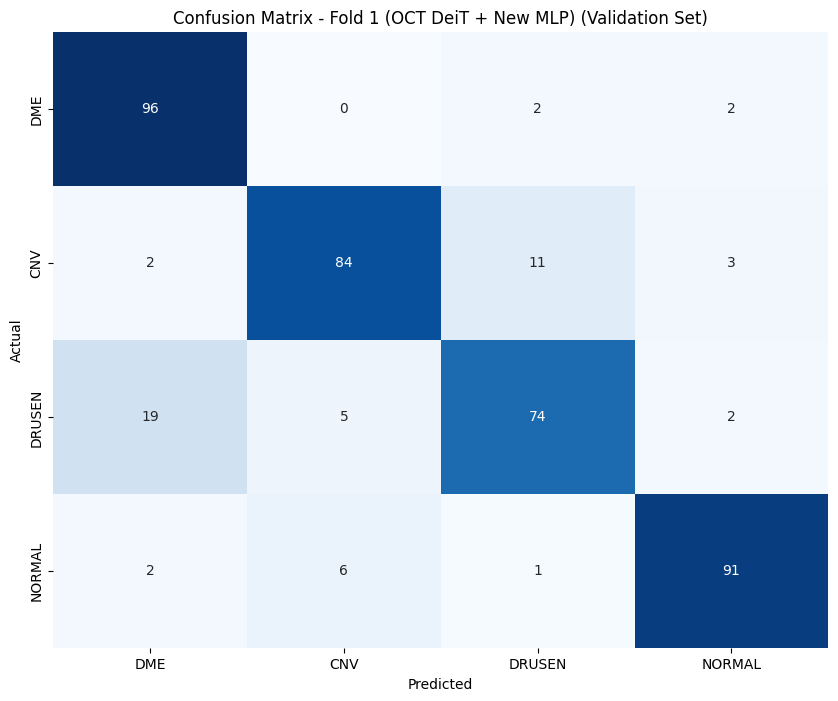

Re-initializing module because the following parameters were re-set: output_features.


Using cache found in C:\Users\Owner/.cache\torch\hub\facebookresearch_deit_main


Re-initializing criterion.
Re-initializing optimizer.
Test Accuracy -> 0.9607438016528925
Test Precision -> 0.9609845896197597
Test Recall -> 0.9607438016528925
Test F1 Score -> 0.9606235098661748
Test AUC-ROC Score -> 0.9959858730050315


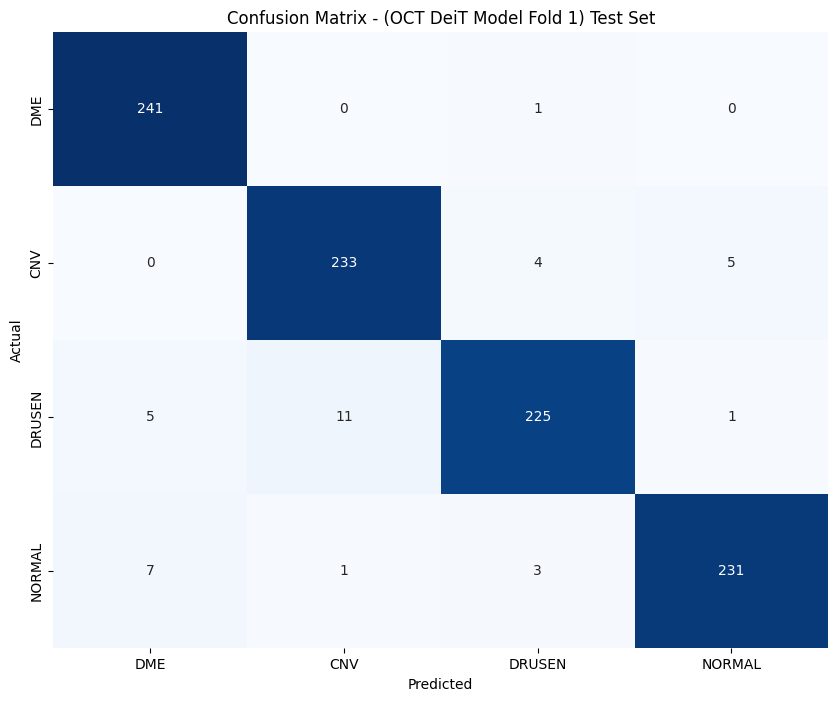

(0.9607438016528925,
 0.9609845896197597,
 0.9607438016528925,
 0.9606235098661748,
 0.9959858730050315)

In [25]:
FOLD_TO_ACCESS = 1
checkpoint, model = train_and_evaluate_model(NAME_OF_EXPERIMENT, FOLD_TO_ACCESS, NEURAL_NETWORK_CONFIG, Model, predefined_split, class_names, csv_file, metrics_per_fold, trained_models)
get_metrics(model, TEST, 'OCT DeiT Model Fold 1', classification_type='multiclass', data_type='test', checkpoint_path=checkpoint) # For test set

### Train Fold 2

Using cache found in C:\Users\Owner/.cache\torch\hub\facebookresearch_deit_main


  epoch    train_loss    valid_acc    valid_f1    valid_loss    valid_precision    valid_recall    valid_roc_auc    cp      lr      dur
-------  ------------  -----------  ----------  ------------  -----------------  --------------  ---------------  ----  ------  -------
      1        0.8940       0.7550      0.7568        0.6234             0.7699          0.7550           0.9255     +  0.0010  89.9047
      2        0.6064       0.8150      0.8114        0.5021             0.8155          0.8150           0.9496     +  0.0010  81.3229
      3        0.5025       0.8200      0.8157        0.4667             0.8248          0.8200           0.9574     +  0.0010  81.2659
      4        0.4514       0.8300      0.8284        0.4437             0.8353          0.8300           0.9615     +  0.0010  81.4726
      5        0.4257       0.8375      0.8395        0.4274             0.8474          0.8375           0.9649     +  0.0010  81.2829
      6        0.4260       0.8425      0.8421  

Using cache found in C:\Users\Owner/.cache\torch\hub\facebookresearch_deit_main


Re-initializing criterion.
Re-initializing optimizer.
Validation Accuracy for Fold 2 -> 0.8975
Validation Precision for Fold 2 -> 0.8984519725557462
Validation Recall for Fold 2 -> 0.8975000000000001
Validation F1 Score for Fold 2 -> 0.8967222681264203
Validation AUC-ROC Score for Fold 2 -> 0.9801000000000001
Metrics for each fold saved to OCT DeiT + New MLP_validation_results.csv
[[92  0  4  4]
 [ 1 93  4  2]
 [ 9  5 80  6]
 [ 4  2  0 94]]


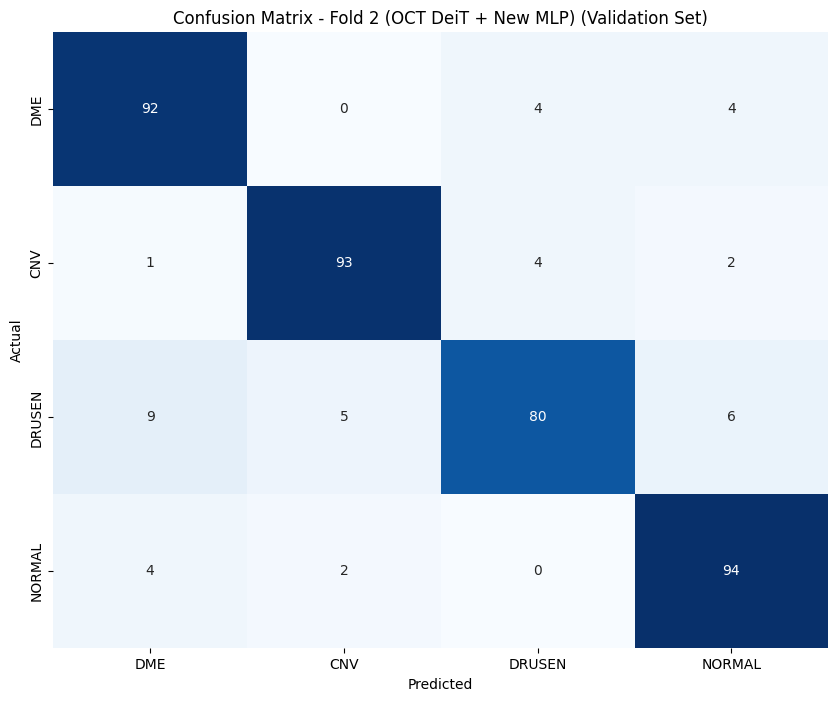

Re-initializing module because the following parameters were re-set: output_features.


Using cache found in C:\Users\Owner/.cache\torch\hub\facebookresearch_deit_main


Re-initializing criterion.
Re-initializing optimizer.
Test Accuracy -> 0.96900826446281
Test Precision -> 0.9691367294411157
Test Recall -> 0.96900826446281
Test F1 Score -> 0.9689480581022287
Test AUC-ROC Score -> 0.9967656466999066


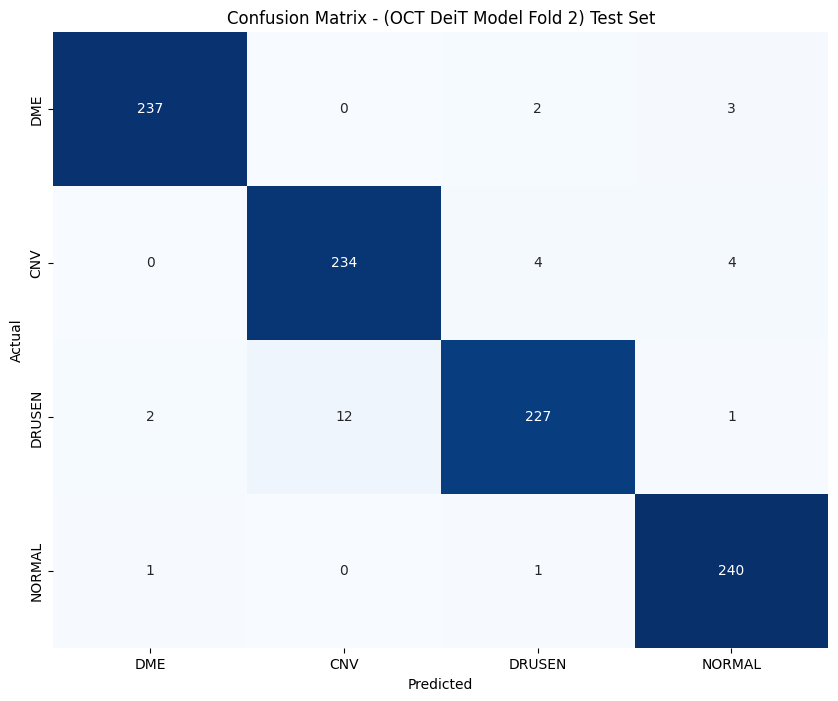

(0.96900826446281,
 0.9691367294411157,
 0.96900826446281,
 0.9689480581022287,
 0.9967656466999066)

In [26]:
FOLD_TO_ACCESS = 2
checkpoint, model = train_and_evaluate_model(NAME_OF_EXPERIMENT, FOLD_TO_ACCESS, NEURAL_NETWORK_CONFIG, Model, predefined_split, class_names, csv_file, metrics_per_fold, trained_models)
get_metrics(model, TEST, 'OCT DeiT Model Fold 2', classification_type='multiclass', data_type='test', checkpoint_path=checkpoint) # For test set

### Train Fold 3

Using cache found in C:\Users\Owner/.cache\torch\hub\facebookresearch_deit_main


  epoch    train_loss    valid_acc    valid_f1    valid_loss    valid_precision    valid_recall    valid_roc_auc    cp      lr      dur
-------  ------------  -----------  ----------  ------------  -----------------  --------------  ---------------  ----  ------  -------
      1        0.9075       0.7875      0.7864        0.5659             0.8032          0.7875           0.9450     +  0.0010  58.6843
      2        0.6002       0.8150      0.8169        0.4808             0.8241          0.8150           0.9567     +  0.0010  58.5578
      3        0.5006       0.8300      0.8282        0.4501             0.8315          0.8300           0.9610     +  0.0010  58.4937
      4        0.4533       0.8400      0.8414        0.4220             0.8479          0.8400           0.9658     +  0.0010  58.5477
      5        0.4410       0.8325      0.8320        0.4394             0.8369          0.8325           0.9660        0.0010  58.4466
      6        0.3999       0.8500      0.8491  

Using cache found in C:\Users\Owner/.cache\torch\hub\facebookresearch_deit_main


Re-initializing criterion.
Re-initializing optimizer.
Validation Accuracy for Fold 3 -> 0.8775
Validation Precision for Fold 3 -> 0.8789135149472633
Validation Recall for Fold 3 -> 0.8775
Validation F1 Score for Fold 3 -> 0.8768117150529136
Validation AUC-ROC Score for Fold 3 -> 0.9794583333333333
Metrics for each fold saved to OCT DeiT + New MLP_validation_results.csv
[[90  0  3  7]
 [ 1 92  6  1]
 [14  4 77  5]
 [ 4  2  2 92]]


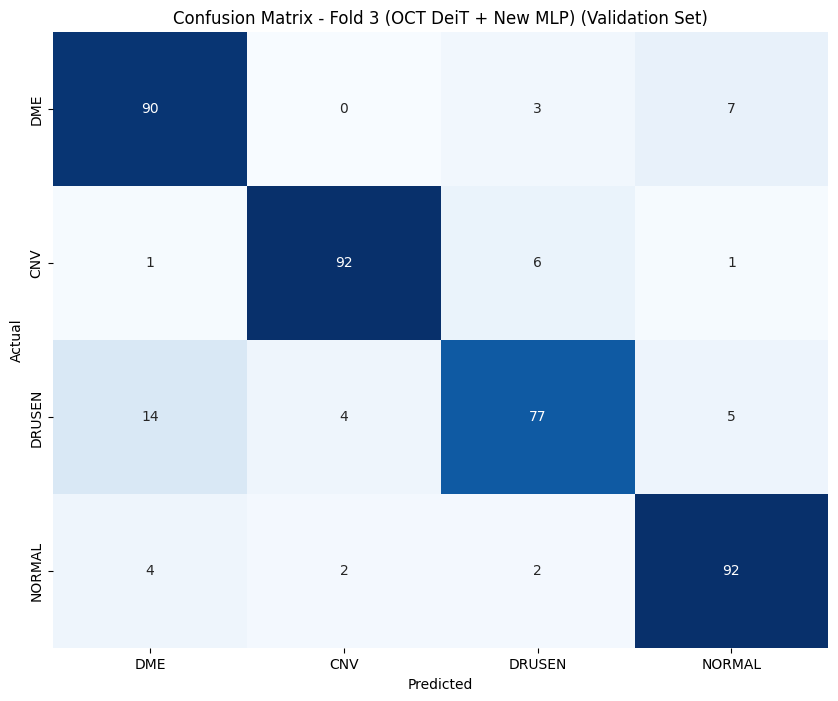

Re-initializing module because the following parameters were re-set: output_features.


Using cache found in C:\Users\Owner/.cache\torch\hub\facebookresearch_deit_main


Re-initializing criterion.
Re-initializing optimizer.
Test Accuracy -> 0.9679752066115702
Test Precision -> 0.9680459150962061
Test Recall -> 0.9679752066115702
Test F1 Score -> 0.9679341726131742
Test AUC-ROC Score -> 0.9971284975980693


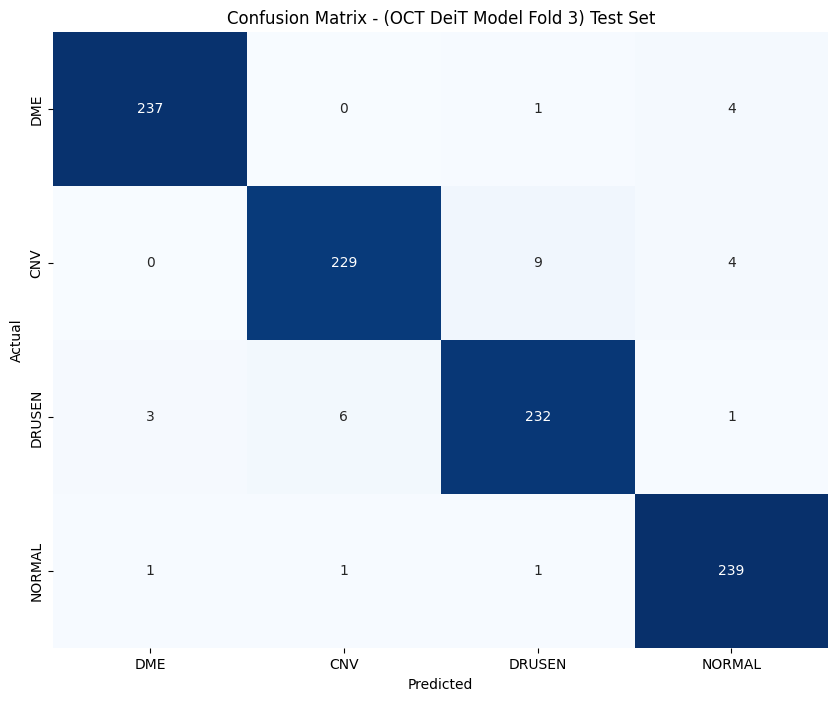

(0.9679752066115702,
 0.9680459150962061,
 0.9679752066115702,
 0.9679341726131742,
 0.9971284975980693)

In [27]:
FOLD_TO_ACCESS = 3
checkpoint, model = train_and_evaluate_model(NAME_OF_EXPERIMENT, FOLD_TO_ACCESS, NEURAL_NETWORK_CONFIG, Model, predefined_split, class_names, csv_file, metrics_per_fold, trained_models)
get_metrics(model, TEST, 'OCT DeiT Model Fold 3', classification_type='multiclass', data_type='test', checkpoint_path=checkpoint) # For test set

### Train Fold 4

Using cache found in C:\Users\Owner/.cache\torch\hub\facebookresearch_deit_main


  epoch    train_loss    valid_acc    valid_f1    valid_loss    valid_precision    valid_recall    valid_roc_auc    cp      lr      dur
-------  ------------  -----------  ----------  ------------  -----------------  --------------  ---------------  ----  ------  -------
      1        0.9055       0.7200      0.7055        0.6785             0.7478          0.7200           0.9299     +  0.0010  98.7978
      2        0.5933       0.8175      0.8138        0.4978             0.8202          0.8175           0.9528     +  0.0010  112.6975
      3        0.5071       0.8150      0.8106        0.4876             0.8273          0.8150           0.9572        0.0010  88.7553
      4        0.4434       0.8525      0.8490        0.4474             0.8587          0.8525           0.9614     +  0.0010  112.6439
      5        0.4402       0.8325      0.8267        0.4396             0.8412          0.8325           0.9623        0.0010  105.8420
      6        0.4016       0.8450      0.839

Using cache found in C:\Users\Owner/.cache\torch\hub\facebookresearch_deit_main


Re-initializing criterion.
Re-initializing optimizer.
Validation Accuracy for Fold 4 -> 0.855
Validation Precision for Fold 4 -> 0.8615830274797667
Validation Recall for Fold 4 -> 0.855
Validation F1 Score for Fold 4 -> 0.8493567740251085
Validation AUC-ROC Score for Fold 4 -> 0.9729166666666667
Metrics for each fold saved to OCT DeiT + New MLP_validation_results.csv
[[93  0  4  3]
 [ 0 97  3  0]
 [12 20 62  6]
 [ 7  3  0 90]]


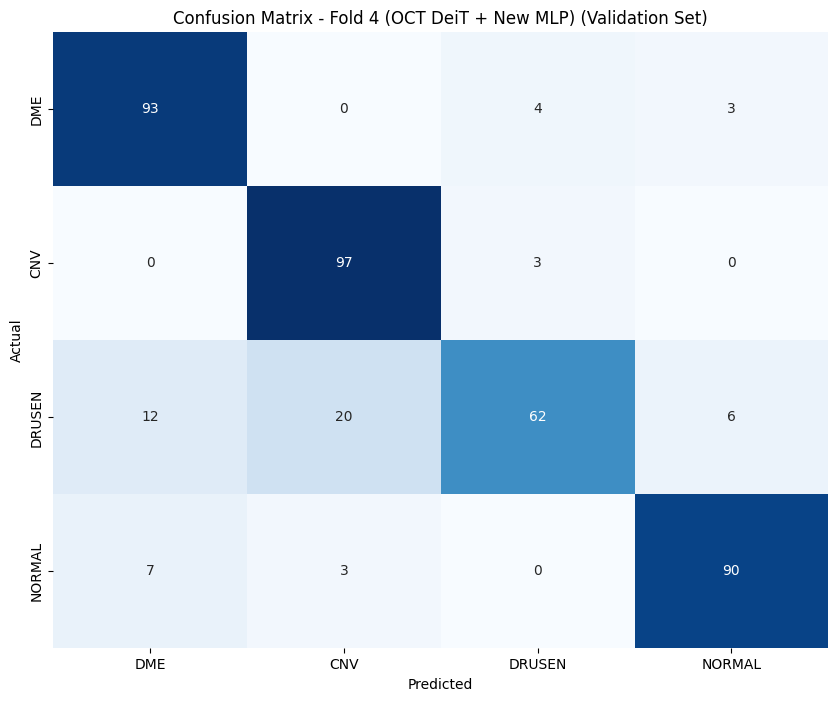

Re-initializing module because the following parameters were re-set: output_features.


Using cache found in C:\Users\Owner/.cache\torch\hub\facebookresearch_deit_main


Re-initializing criterion.
Re-initializing optimizer.
Test Accuracy -> 0.9514462809917356
Test Precision -> 0.9544238387867197
Test Recall -> 0.9514462809917356
Test F1 Score -> 0.951206448603052
Test AUC-ROC Score -> 0.9965849327231746


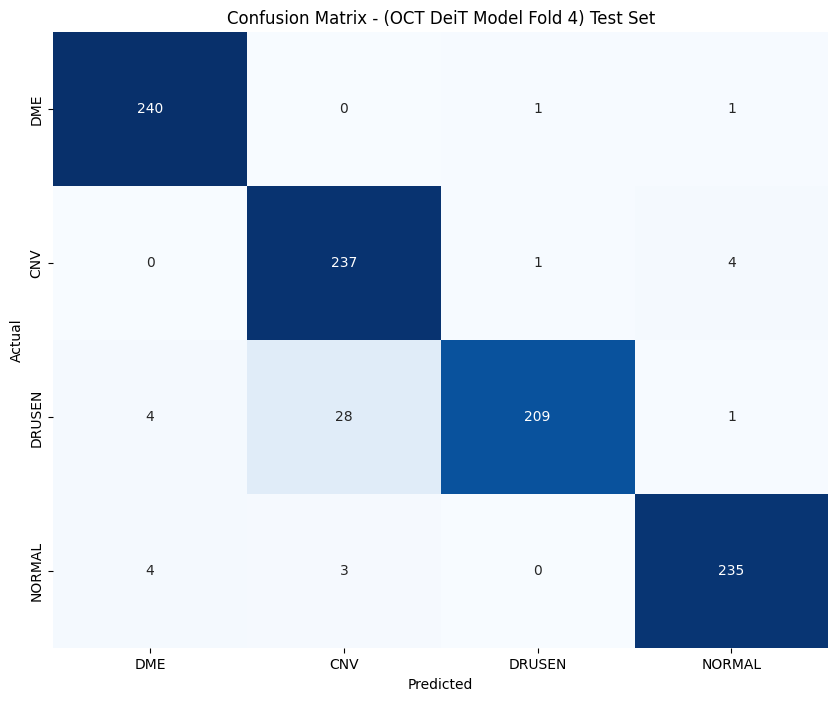

(0.9514462809917356,
 0.9544238387867197,
 0.9514462809917356,
 0.951206448603052,
 0.9965849327231746)

In [28]:
FOLD_TO_ACCESS = 4
checkpoint, model = train_and_evaluate_model(NAME_OF_EXPERIMENT, FOLD_TO_ACCESS, NEURAL_NETWORK_CONFIG, Model, predefined_split, class_names, csv_file, metrics_per_fold, trained_models)
get_metrics(model, TEST, 'OCT DeiT Model Fold 4', classification_type='multiclass', data_type='test', checkpoint_path=checkpoint) # For test set

### Train Fold 5

Using cache found in C:\Users\Owner/.cache\torch\hub\facebookresearch_deit_main


  epoch    train_loss    valid_acc    valid_f1    valid_loss    valid_precision    valid_recall    valid_roc_auc    cp      lr      dur
-------  ------------  -----------  ----------  ------------  -----------------  --------------  ---------------  ----  ------  -------
      1        0.9340       0.7525      0.7369        0.6610             0.7717          0.7525           0.9322     +  0.0010  86.4599
      2        0.5961       0.8200      0.8142        0.5203             0.8387          0.8200           0.9536     +  0.0010  102.6781
      3        0.4937       0.8425      0.8405        0.4733             0.8515          0.8425           0.9588     +  0.0010  106.5749
      4        0.4582       0.8450      0.8448        0.4444             0.8447          0.8450           0.9621     +  0.0010  98.2000
      5        0.4243       0.8475      0.8457        0.4525             0.8515          0.8475           0.9619     +  0.0010  106.3053
      6        0.3935       0.8500      0.847

Using cache found in C:\Users\Owner/.cache\torch\hub\facebookresearch_deit_main


Re-initializing criterion.
Re-initializing optimizer.
Validation Accuracy for Fold 5 -> 0.88
Validation Precision for Fold 5 -> 0.8802099348834924
Validation Recall for Fold 5 -> 0.88
Validation F1 Score for Fold 5 -> 0.8797083010099975
Validation AUC-ROC Score for Fold 5 -> 0.9750749999999999
Metrics for each fold saved to OCT DeiT + New MLP_validation_results.csv
[[90  1  2  7]
 [ 0 91  9  0]
 [11  6 81  2]
 [ 5  3  2 90]]


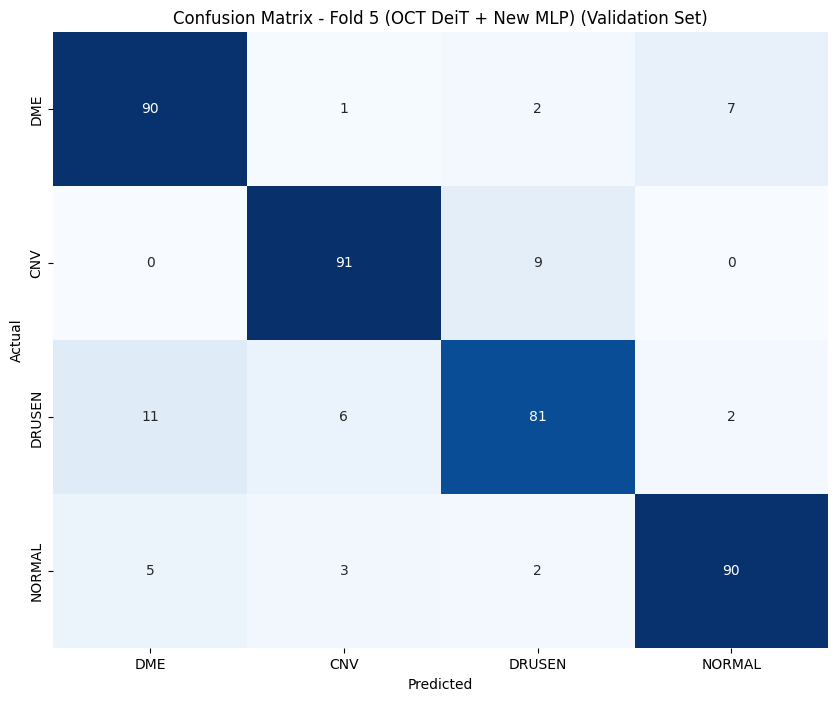

Re-initializing module because the following parameters were re-set: output_features.


Using cache found in C:\Users\Owner/.cache\torch\hub\facebookresearch_deit_main


Re-initializing criterion.
Re-initializing optimizer.
Test Accuracy -> 0.9669421487603306
Test Precision -> 0.966861175286896
Test Recall -> 0.9669421487603306
Test F1 Score -> 0.9668015424568419
Test AUC-ROC Score -> 0.9965465132163104


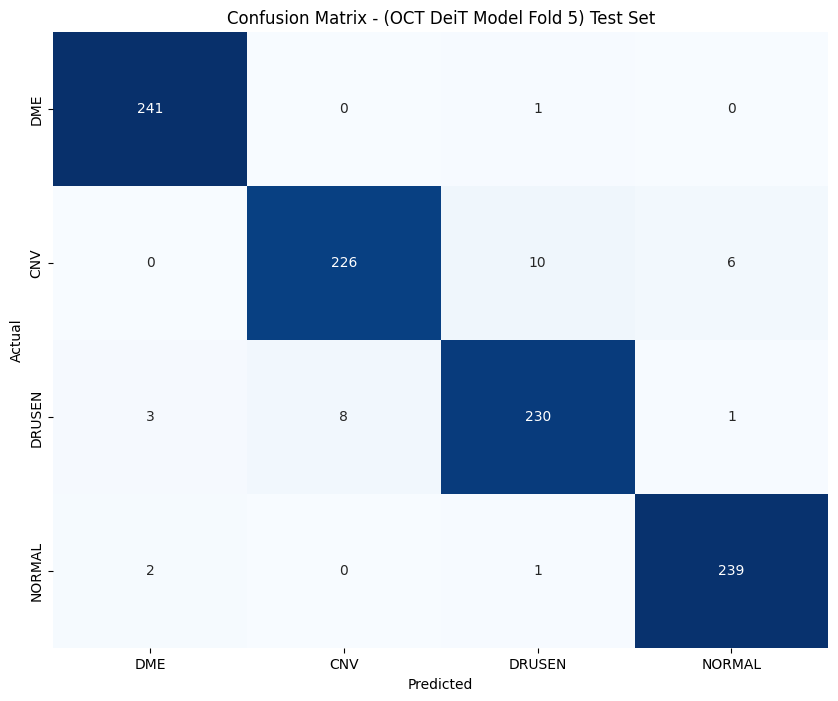

(0.9669421487603306,
 0.966861175286896,
 0.9669421487603306,
 0.9668015424568419,
 0.9965465132163104)

In [29]:
FOLD_TO_ACCESS = 5
checkpoint, model = train_and_evaluate_model(NAME_OF_EXPERIMENT, FOLD_TO_ACCESS, NEURAL_NETWORK_CONFIG, Model, predefined_split, class_names, csv_file, metrics_per_fold, trained_models)
get_metrics(model, TEST, 'OCT DeiT Model Fold 5', classification_type='multiclass', data_type='test', checkpoint_path=checkpoint) # For test set

### Train Fold 6

Using cache found in C:\Users\Owner/.cache\torch\hub\facebookresearch_deit_main


  epoch    train_loss    valid_acc    valid_f1    valid_loss    valid_precision    valid_recall    valid_roc_auc    cp      lr      dur
-------  ------------  -----------  ----------  ------------  -----------------  --------------  ---------------  ----  ------  -------
      1        0.8879       0.7750      0.7727        0.6116             0.7749          0.7750           0.9293     +  0.0010  88.0778
      2        0.5723       0.7675      0.7651        0.5862             0.7759          0.7675           0.9388        0.0010  105.2842
      3        0.4860       0.8175      0.8152        0.5248             0.8154          0.8175           0.9458     +  0.0010  104.9868
      4        0.4448       0.8000      0.8005        0.5130             0.8034          0.8000           0.9495        0.0010  105.1303
      5        0.4148       0.8125      0.8126        0.5092             0.8178          0.8125           0.9526        0.0010  107.6817
      6        0.3828       0.8150      0.81

Using cache found in C:\Users\Owner/.cache\torch\hub\facebookresearch_deit_main


Re-initializing criterion.
Re-initializing optimizer.
Validation Accuracy for Fold 6 -> 0.865
Validation Precision for Fold 6 -> 0.8668578739522889
Validation Recall for Fold 6 -> 0.8650000000000001
Validation F1 Score for Fold 6 -> 0.8651188722911846
Validation AUC-ROC Score for Fold 6 -> 0.9691083333333333
Metrics for each fold saved to OCT DeiT + New MLP_validation_results.csv
[[93  0  5  2]
 [ 0 86 12  2]
 [14  5 78  3]
 [ 3  3  5 89]]


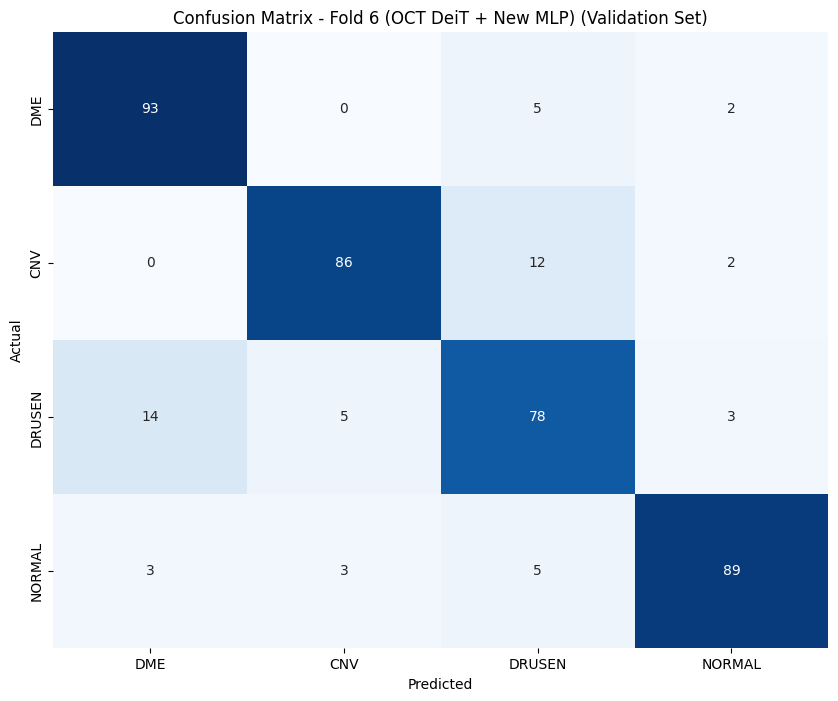

Re-initializing module because the following parameters were re-set: output_features.


Using cache found in C:\Users\Owner/.cache\torch\hub\facebookresearch_deit_main


Re-initializing criterion.
Re-initializing optimizer.
Test Accuracy -> 0.9710743801652892
Test Precision -> 0.9712244854570105
Test Recall -> 0.9710743801652892
Test F1 Score -> 0.9710386094846091
Test AUC-ROC Score -> 0.9968794822758008


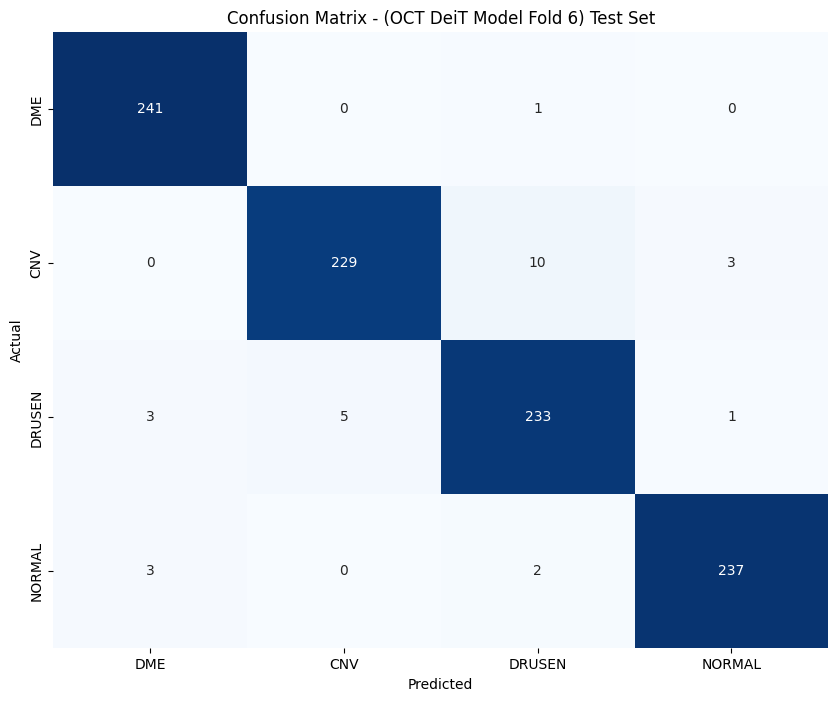

(0.9710743801652892,
 0.9712244854570105,
 0.9710743801652892,
 0.9710386094846091,
 0.9968794822758008)

In [30]:
FOLD_TO_ACCESS = 6
checkpoint, model = train_and_evaluate_model(NAME_OF_EXPERIMENT, FOLD_TO_ACCESS, NEURAL_NETWORK_CONFIG, Model, predefined_split, class_names, csv_file, metrics_per_fold, trained_models)
get_metrics(model, TEST, 'OCT DeiT Model Fold 6', classification_type='multiclass', data_type='test', checkpoint_path=checkpoint) # For test set

### Train Fold 7

Using cache found in C:\Users\Owner/.cache\torch\hub\facebookresearch_deit_main


  epoch    train_loss    valid_acc    valid_f1    valid_loss    valid_precision    valid_recall    valid_roc_auc    cp      lr      dur
-------  ------------  -----------  ----------  ------------  -----------------  --------------  ---------------  ----  ------  -------
      1        0.9042       0.7025      0.6962        0.7105             0.7187          0.7025           0.9256     +  0.0010  90.9086
      2        0.6083       0.7800      0.7807        0.5469             0.7845          0.7800           0.9470     +  0.0010  89.9459
      3        0.4948       0.7975      0.7988        0.4877             0.8027          0.7975           0.9562     +  0.0010  88.7597
      4        0.4521       0.8000      0.7986        0.4836             0.8027          0.8000           0.9581     +  0.0010  89.8148
      5        0.4378       0.8050      0.8054        0.4656             0.8077          0.8050           0.9598     +  0.0010  89.7853
      6        0.4009       0.8225      0.8156  

Using cache found in C:\Users\Owner/.cache\torch\hub\facebookresearch_deit_main


Re-initializing criterion.
Re-initializing optimizer.
Validation Accuracy for Fold 7 -> 0.865
Validation Precision for Fold 7 -> 0.8650495984979432
Validation Recall for Fold 7 -> 0.865
Validation F1 Score for Fold 7 -> 0.8642792836791614
Validation AUC-ROC Score for Fold 7 -> 0.9728749999999999
Metrics for each fold saved to OCT DeiT + New MLP_validation_results.csv
[[90  0  6  4]
 [ 0 89  9  2]
 [17  7 75  1]
 [ 2  4  2 92]]


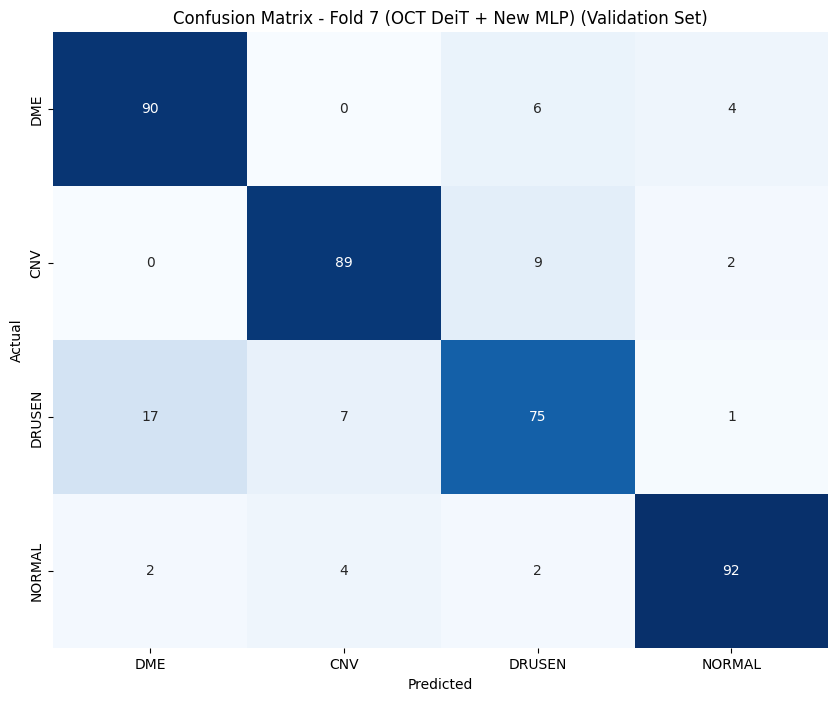

Re-initializing module because the following parameters were re-set: output_features.


Using cache found in C:\Users\Owner/.cache\torch\hub\facebookresearch_deit_main


Re-initializing criterion.
Re-initializing optimizer.
Test Accuracy -> 0.9710743801652892
Test Precision -> 0.9710423256897115
Test Recall -> 0.9710743801652892
Test F1 Score -> 0.9710044654859564
Test AUC-ROC Score -> 0.9972636773444438


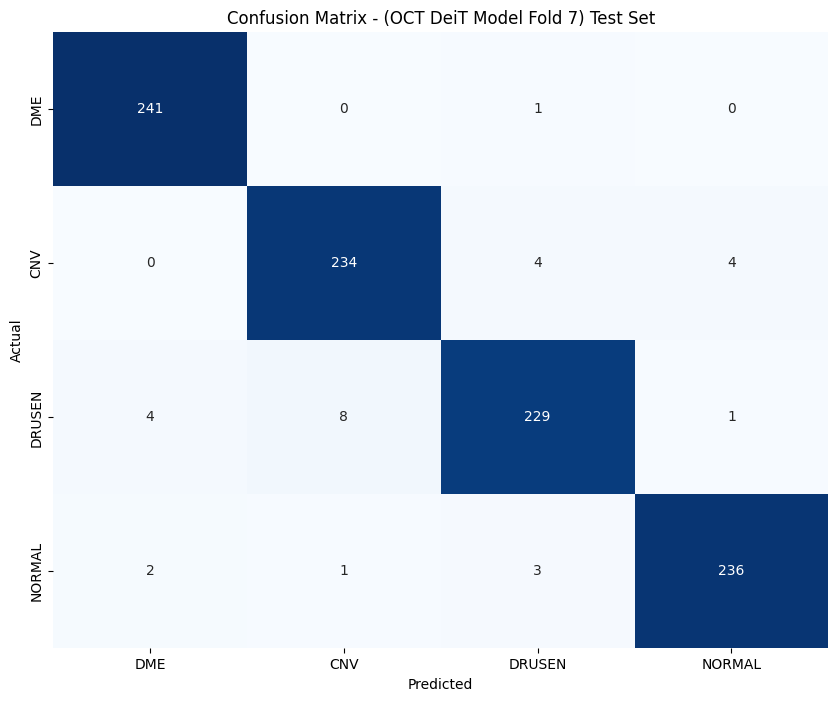

(0.9710743801652892,
 0.9710423256897115,
 0.9710743801652892,
 0.9710044654859564,
 0.9972636773444438)

In [31]:
FOLD_TO_ACCESS = 7
checkpoint, model = train_and_evaluate_model(NAME_OF_EXPERIMENT, FOLD_TO_ACCESS, NEURAL_NETWORK_CONFIG, Model, predefined_split, class_names, csv_file, metrics_per_fold, trained_models)
get_metrics(model, TEST, 'OCT DeiT Model Fold 7', classification_type='multiclass', data_type='test', checkpoint_path=checkpoint) # For test set

### Train Fold 8

Using cache found in C:\Users\Owner/.cache\torch\hub\facebookresearch_deit_main


  epoch    train_loss    valid_acc    valid_f1    valid_loss    valid_precision    valid_recall    valid_roc_auc    cp      lr      dur
-------  ------------  -----------  ----------  ------------  -----------------  --------------  ---------------  ----  ------  -------
      1        0.8715       0.7625      0.7591        0.6482             0.7609          0.7625           0.9234     +  0.0010  85.7189
      2        0.5555       0.7900      0.7903        0.5468             0.7916          0.7900           0.9440     +  0.0010  86.9752
      3        0.4709       0.8050      0.8025        0.4937             0.8037          0.8050           0.9522     +  0.0010  89.8092
      4        0.4316       0.8000      0.7968        0.5033             0.7988          0.8000           0.9528        0.0010  87.1676
      5        0.4139       0.8100      0.8094        0.4893             0.8115          0.8100           0.9562     +  0.0010  88.4279
      6        0.3712       0.8225      0.8236  

Using cache found in C:\Users\Owner/.cache\torch\hub\facebookresearch_deit_main


Re-initializing criterion.
Re-initializing optimizer.
Validation Accuracy for Fold 8 -> 0.855
Validation Precision for Fold 8 -> 0.8551725303041381
Validation Recall for Fold 8 -> 0.855
Validation F1 Score for Fold 8 -> 0.8543427955423697
Validation AUC-ROC Score for Fold 8 -> 0.9671500000000001
Metrics for each fold saved to OCT DeiT + New MLP_validation_results.csv
[[92  0  6  2]
 [ 1 85  9  5]
 [ 8 11 77  4]
 [ 9  1  2 88]]


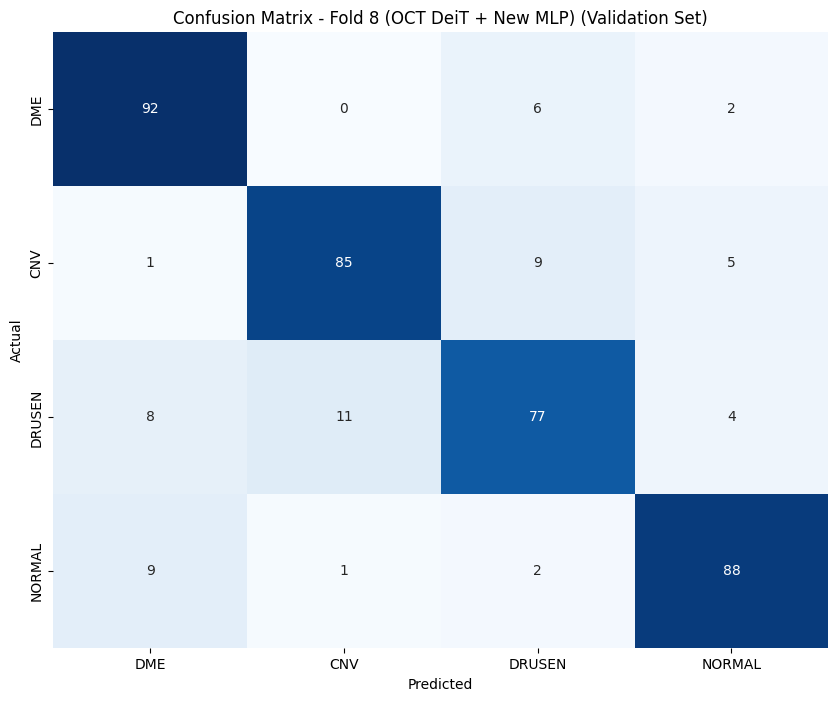

Re-initializing module because the following parameters were re-set: output_features.


Using cache found in C:\Users\Owner/.cache\torch\hub\facebookresearch_deit_main


Re-initializing criterion.
Re-initializing optimizer.
Test Accuracy -> 0.9679752066115702
Test Precision -> 0.9680034915339085
Test Recall -> 0.9679752066115703
Test F1 Score -> 0.9678875759161021
Test AUC-ROC Score -> 0.9966261981194363


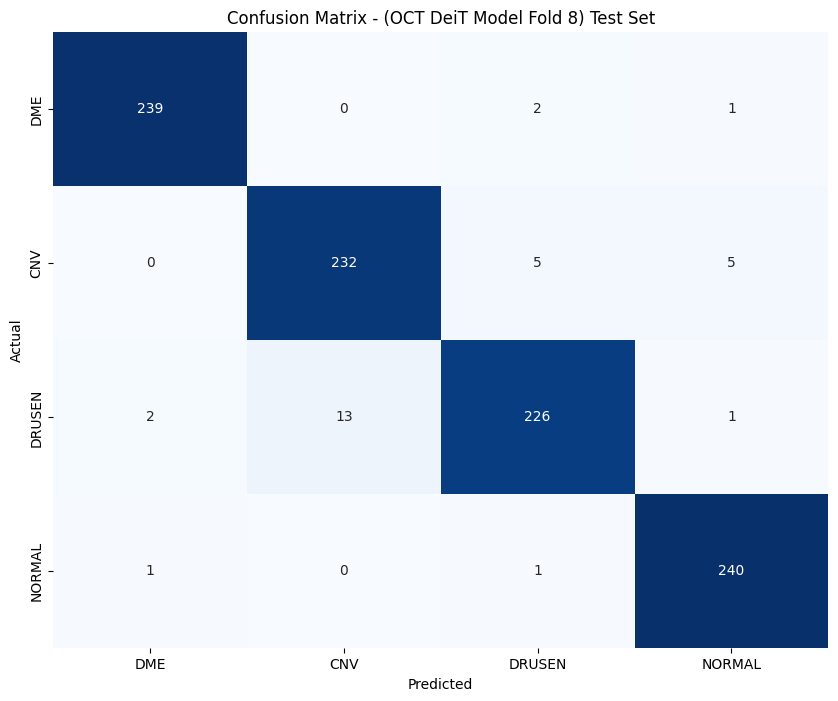

(0.9679752066115702,
 0.9680034915339085,
 0.9679752066115703,
 0.9678875759161021,
 0.9966261981194363)

In [32]:
FOLD_TO_ACCESS = 8
checkpoint, model = train_and_evaluate_model(NAME_OF_EXPERIMENT, FOLD_TO_ACCESS, NEURAL_NETWORK_CONFIG, Model, predefined_split, class_names, csv_file, metrics_per_fold, trained_models)
get_metrics(model, TEST, 'OCT DeiT Model Fold 8', classification_type='multiclass', data_type='test', checkpoint_path=checkpoint) # For test set

### Train Fold 9

Using cache found in C:\Users\Owner/.cache\torch\hub\facebookresearch_deit_main


  epoch    train_loss    valid_acc    valid_f1    valid_loss    valid_precision    valid_recall    valid_roc_auc    cp      lr      dur
-------  ------------  -----------  ----------  ------------  -----------------  --------------  ---------------  ----  ------  -------
      1        0.8817       0.7200      0.7093        0.7441             0.7471          0.7200           0.9218     +  0.0010  59.9650
      2        0.5874       0.7675      0.7666        0.5800             0.7864          0.7675           0.9434     +  0.0010  58.0362
      3        0.4997       0.7725      0.7699        0.5289             0.7771          0.7725           0.9514     +  0.0010  57.9729
      4        0.4568       0.7950      0.7930        0.5077             0.8072          0.7950           0.9565     +  0.0010  58.4097
      5        0.4198       0.8075      0.8040        0.4630             0.8096          0.8075           0.9610     +  0.0010  80.5553
      6        0.4066       0.8075      0.8015  

Using cache found in C:\Users\Owner/.cache\torch\hub\facebookresearch_deit_main


Re-initializing criterion.
Re-initializing optimizer.
Validation Accuracy for Fold 9 -> 0.845
Validation Precision for Fold 9 -> 0.8505359777666249
Validation Recall for Fold 9 -> 0.845
Validation F1 Score for Fold 9 -> 0.8400260331532223
Validation AUC-ROC Score for Fold 9 -> 0.96765
Metrics for each fold saved to OCT DeiT + New MLP_validation_results.csv
[[90  1  1  8]
 [ 0 95  2  3]
 [13 18 63  6]
 [ 3  3  4 90]]


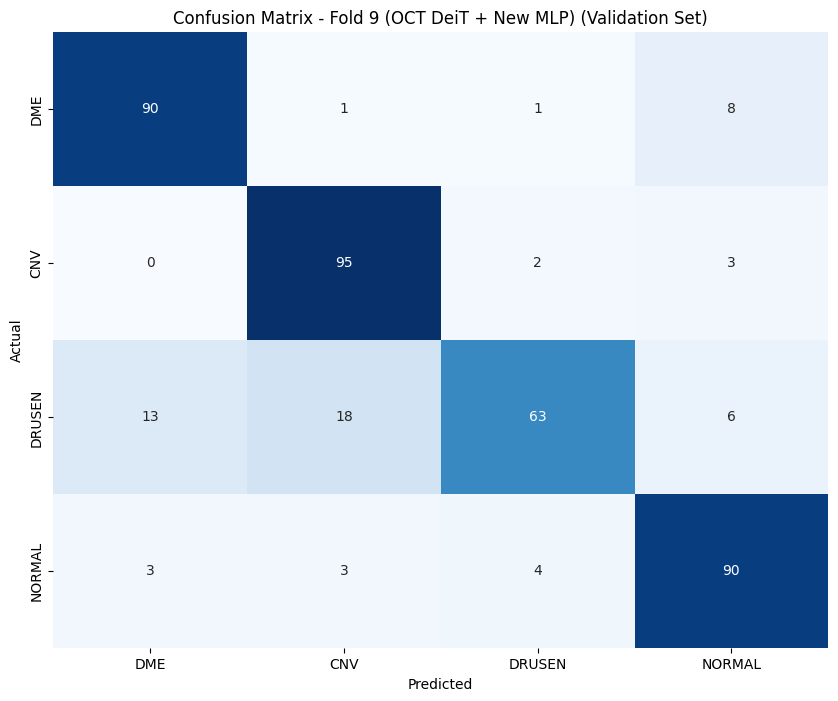

Re-initializing module because the following parameters were re-set: output_features.


Using cache found in C:\Users\Owner/.cache\torch\hub\facebookresearch_deit_main


Re-initializing criterion.
Re-initializing optimizer.
Test Accuracy -> 0.9390495867768595
Test Precision -> 0.9435339186683896
Test Recall -> 0.9390495867768596
Test F1 Score -> 0.9385918409065044
Test AUC-ROC Score -> 0.9961594722582701


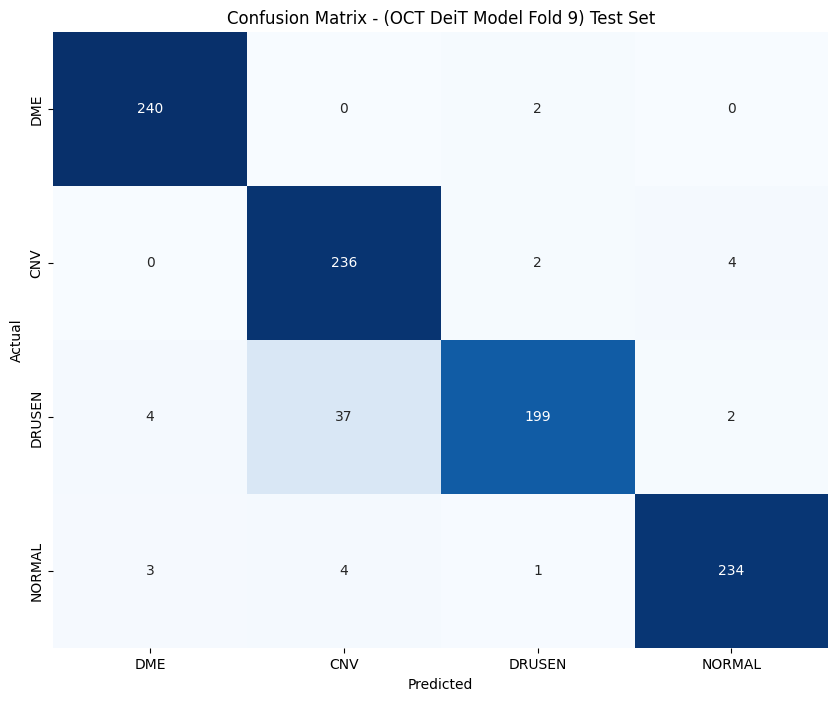

(0.9390495867768595,
 0.9435339186683896,
 0.9390495867768596,
 0.9385918409065044,
 0.9961594722582701)

In [33]:
FOLD_TO_ACCESS = 9
checkpoint, model = train_and_evaluate_model(NAME_OF_EXPERIMENT, FOLD_TO_ACCESS, NEURAL_NETWORK_CONFIG, Model, predefined_split, class_names, csv_file, metrics_per_fold, trained_models)
get_metrics(model, TEST, 'OCT DeiT Model Fold 9', classification_type='multiclass', data_type='test', checkpoint_path=checkpoint) # For test set

### Train Fold 10

Using cache found in C:\Users\Owner/.cache\torch\hub\facebookresearch_deit_main


  epoch    train_loss    valid_acc    valid_f1    valid_loss    valid_precision    valid_recall    valid_roc_auc    cp      lr      dur
-------  ------------  -----------  ----------  ------------  -----------------  --------------  ---------------  ----  ------  -------
      1        0.9081       0.7125      0.7053        0.6979             0.7377          0.7125           0.9237     +  0.0010  92.7329
      2        0.6313       0.7975      0.7959        0.5233             0.8070          0.7975           0.9528     +  0.0010  91.6045
      3        0.5108       0.7975      0.7896        0.4964             0.8153          0.7975           0.9607        0.0010  92.3302
      4        0.4643       0.8150      0.8130        0.4881             0.8357          0.8150           0.9620     +  0.0010  89.2657
      5        0.4429       0.8250      0.8224        0.4677             0.8459          0.8250           0.9632     +  0.0010  91.1998
      6        0.4190       0.8300      0.8259  

Using cache found in C:\Users\Owner/.cache\torch\hub\facebookresearch_deit_main


Re-initializing criterion.
Re-initializing optimizer.
Validation Accuracy for Fold 10 -> 0.86
Validation Precision for Fold 10 -> 0.8676532585139239
Validation Recall for Fold 10 -> 0.86
Validation F1 Score for Fold 10 -> 0.8563029677580761
Validation AUC-ROC Score for Fold 10 -> 0.970275
Metrics for each fold saved to OCT DeiT + New MLP_validation_results.csv
[[88  3  2  7]
 [ 0 96  2  2]
 [11 15 67  7]
 [ 5  2  0 93]]


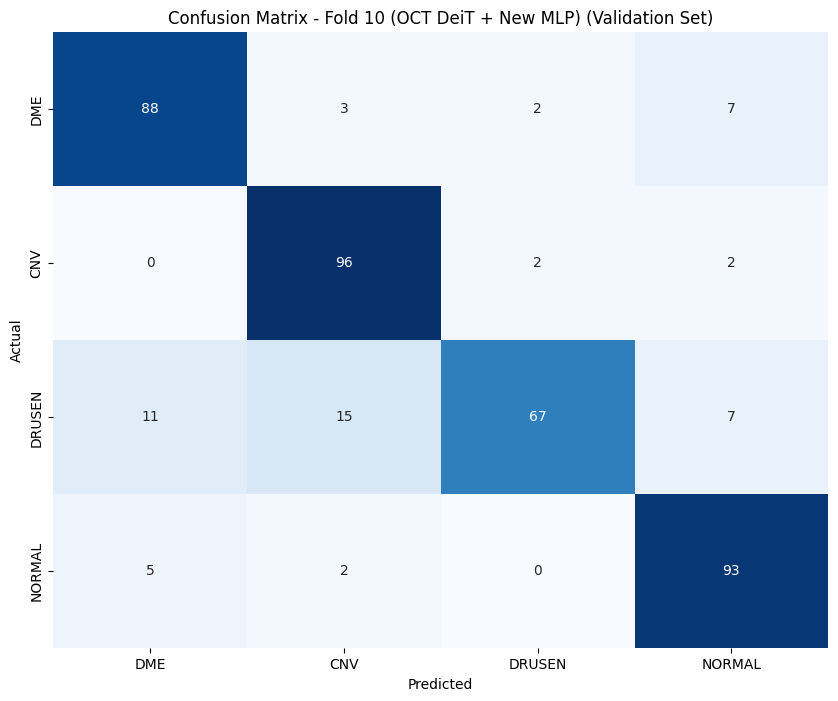

Re-initializing module because the following parameters were re-set: output_features.


Using cache found in C:\Users\Owner/.cache\torch\hub\facebookresearch_deit_main


Re-initializing criterion.
Re-initializing optimizer.
Test Accuracy -> 0.9287190082644629
Test Precision -> 0.9323459945926214
Test Recall -> 0.9287190082644627
Test F1 Score -> 0.928187768454122
Test AUC-ROC Score -> 0.9949556610431892


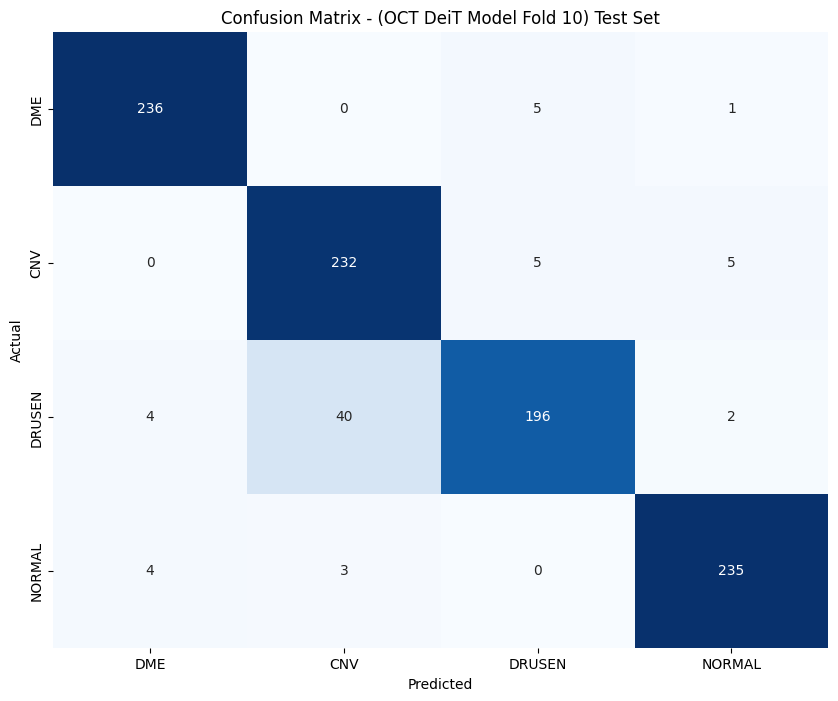

(0.9287190082644629,
 0.9323459945926214,
 0.9287190082644627,
 0.928187768454122,
 0.9949556610431892)

In [34]:
FOLD_TO_ACCESS = 10
checkpoint, model = train_and_evaluate_model(NAME_OF_EXPERIMENT, FOLD_TO_ACCESS, NEURAL_NETWORK_CONFIG, Model, predefined_split, class_names, csv_file, metrics_per_fold, trained_models)
get_metrics(model, TEST, 'OCT DeiT Model Fold 10', classification_type='multiclass', data_type='test', checkpoint_path=checkpoint) # For test set

## Average validation performance metrics across all folds

In [35]:
# Calculating the average validation performance metrics across all folds
average_accuracy = np.mean(accuracies)
average_precision = np.mean(precisions)
average_recall = np.mean(recalls)
average_f1 = np.mean(f1_scores)
average_auc_roc = np.mean(auc_roc_scores)

# Displaying the average validation performance metrics across all folds
print(f'Average Validation Accuracy across {NEURAL_NETWORK_CONFIG.NUMBER_OF_FOLDS} Folds -> {average_accuracy}')
print(f'Average Validation Precision across {NEURAL_NETWORK_CONFIG.NUMBER_OF_FOLDS} Folds -> {average_precision}')
print(f'Average Validation Recall across {NEURAL_NETWORK_CONFIG.NUMBER_OF_FOLDS} Folds -> {average_recall}')
print(f'Average Validation F1 Score across {NEURAL_NETWORK_CONFIG.NUMBER_OF_FOLDS} Folds -> {average_f1}')
print(f'Average Validation AUC ROC Score across {NEURAL_NETWORK_CONFIG.NUMBER_OF_FOLDS} Folds -> {average_auc_roc}')


# Creating a dataframe that contains the average validation performance metrics
average_performance_metrics = pd.DataFrame({
    'Model_Name': [NAME_OF_EXPERIMENT],
    'Number of Folds': [NEURAL_NETWORK_CONFIG.NUMBER_OF_FOLDS],
    'Average Validation Accuracy': [average_accuracy],
    'Average Validation Precision': [average_precision],
    'Average Validation Recall': [average_recall],
    'Average Validation F1 Score': [average_f1],
    'Average Validation AUC-ROC': [average_auc_roc]
})

# Save the dataframe that contains the average validation performance metrics to CSV
average_performance_metrics.to_csv(f'{NAME_OF_EXPERIMENT}_average_validation_results.csv', index=False)


Average Validation Accuracy across 10 Folds -> 0.86625
Average Validation Precision across 10 Folds -> 0.8689531122619172
Average Validation Recall across 10 Folds -> 0.86625
Average Validation F1 Score across 10 Folds -> 0.8643838198651128
Average Validation AUC ROC Score across 10 Folds -> 0.9726524999999999
